# Team 6 Project: MINJUSTICIA

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
import seaborn as sns
from scipy import stats
pd.options.display.max_columns = 50
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
import plotly.express as px

import scipy.stats as stats
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

%matplotlib inline

path = "C:/Users/david/Desktop/ds4a-team6/retomintic/Data_UpdateJune13/reincidencia11junio2020_clean.csv"
df_mj = pd.read_csv(path, sep=",",encoding="utf-8")

C:\Users\david\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Processing

## 1. Data cleaning and tentative transformations

In [2]:
#Date variables are parsed to datetime
df_mj["FECHA_CAPTURA"] = pd.to_datetime(df_mj["FECHA_CAPTURA"])
df_mj["FECHA_INGRESO"] = pd.to_datetime(df_mj["FECHA_INGRESO"])
df_mj["FECHA_SALIDA"] = pd.to_datetime(df_mj["FECHA_SALIDA"])
#Month and year variables are defined
df_mj["MES_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%m')
df_mj["ANO_INGRESO_INT"]=df_mj["FECHA_INGRESO"].dt.strftime('%y')
#Calculations on how much time have the criminal being outside since its last stay in jail
for column in ['FECHA_INGRESO', 'FECHA_SALIDA', 'FECHA_CAPTURA']:
    df_mj = df_mj.sort_values(['INTERNOEN', column], ascending = False)
    
    df_mj['DIAS' + column[5:]] = -1*(df_mj[column].diff()/timedelta(days = 1))

    df_mj.loc[(df_mj.INTERNOEN != df_mj.INTERNOEN.shift(1)) | (df_mj['DIAS' + column[5:]] == 0), 
              ['DIAS' + column[5:]]] = (datetime.today() - df_mj[column])/timedelta(days = 1)
    
#It seems that sometimes entering and gettint out is switched, that's why we computed in absolute values
df_mj['DIAS_CONDENA'] = abs(df_mj['FECHA_SALIDA'] - df_mj['FECHA_INGRESO'])/timedelta(days = 1)
df_mj['DIAS_JUDICIALIZACION'] = df_mj['FECHA_INGRESO'] - df_mj['FECHA_CAPTURA']
df_mj['DIAS_LIBRE'] = df_mj['DIAS_INGRESO'] - df_mj['DIAS_CONDENA']
#The individual finishes its sentence but she's incarcelated inmediately for another crime
df_mj.loc[df_mj.DIAS_CAPTURA < 0, 'DIAS_CAPTURA'] = 0
df_mj.loc[df_mj.DIAS_INGRESO < 0, 'DIAS_INGRESO'] = 0
df_mj.loc[df_mj.DIAS_LIBRE < 0, 'DIAS_LIBRE'] = 0
#The individual is still on jail
df_mj.loc[df_mj['DIAS_LIBRE'].isnull(), 'DIAS_LIBRE'] = 0

#Find the last date the criminal went out the jail, so that these observations are marked as censored
last_df = df_mj[['INTERNOEN', 'FECHA_INGRESO']].groupby('INTERNOEN').apply(lambda x: x.sort_values('FECHA_INGRESO', ascending = False).head(1)).reset_index(drop = True)
#Censored
last_df['CENSURADO_LIBRES'] = 0
df_mj = df_mj.merge(last_df, on = ['INTERNOEN', 'FECHA_INGRESO'], how = 'left')
#Event
df_mj.loc[df_mj['CENSURADO_LIBRES'].isnull(), 'CENSURADO_LIBRES'] = 1
#All criminals that haven't got out of jail yet have zero days out and they are not censored.
df_mj.loc[df_mj['FECHA_SALIDA'].isnull(), 'CENSURADO_LIBRES'] = 1
#Turned censored variables to integers instead of float
df_mj['CENSURADO_LIBRES'] = df_mj['CENSURADO_LIBRES'].astype('int64')

#We create a variable to count the amount of times the individual re-entered in jail
df_mj = df_mj.merge(df_mj.drop_duplicates(['INTERNOEN', 'FECHA_INGRESO']).groupby(['INTERNOEN']).size().reset_index(name = 'NUMERO_REINCIDENCIAS'), on = 'INTERNOEN', how = 'left')

#We dropped SITUACION_JURIDICA and REINCIDENTE as both columns are constants
df_mj = df_mj.drop(columns = ['SITUACION_JURIDICA', 'REINCIDENTE'])

### Análisis de supervivencia y matching

#### Estudio

In [37]:
index_out = round((datetime.today() - df_mj['FECHA_SALIDA'])/timedelta(days = 1)) != round(df_mj['DIAS_LIBRE'])                                                                                           

In [42]:
df = df_mj[(index_out)&(df_mj['DIAS_LIBRE'] > 0)].copy()
df['NIVEL_EDUCATIVO'] = df['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 14, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

df_mj['EN_CARCEL'] = 0
df_mj.loc[df_mj['ESTADO_INGRESO'].isin(['Espera Traslado', 'Intramuros']),'EN_CARCEL'] = 1

df['ESTADO_INGRESO'] = df['ESTADO_INGRESO'].replace(
            {'Prision Domiciliaria': 'Detencion Domiciliaria',
             'Vigilancia Electronica': 'Intramuros',
             'Control Electronico': 'Intramuros',
             'Espera Traslado': 'Intramuros'
            })

treat_df = df.drop_duplicates('INTERNOEN')
treat_df = treat_df.loc[treat_df['ACTIVIDADES_ESTUDIO'] == 'SI', ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

untreat_df = df.drop_duplicates('INTERNOEN')
untreat_df = untreat_df[(untreat_df['ACTIVIDADES_TRABAJO'] == 'NO') & (untreat_df['ACTIVIDADES_ESTUDIO'] == 'NO') & (untreat_df['ACTIVIDADES_ENSEÑANZA'] == 'NO')]
untreat_df = untreat_df.loc[untreat_df['INTERNOEN'].isin(set(untreat_df['INTERNOEN']).difference(set(treat_df))), ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

dummies_df = pd.get_dummies(df[['ESTADO', 'TENTATIVA', 'AGRAVADO', 'CALIFICADO', 'GENERO', 
                      'REGIONAL', 'ESTADO_INGRESO', 'HIJOS_MENORES', 'ESTADO_CIVIL']], drop_first = True)

dummies_df.columns = [string.replace(' ', '_') for string in dummies_df.columns]
dummies_df.columns = [string.replace('(', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace(')', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace('-', '_')  for string in dummies_df.columns]

treat_df = treat_df.merge(dummies_df, right_index = True, left_index = True)
untreat_df = untreat_df.merge(dummies_df, right_index = True, left_index = True)

drops = list(set(treat_df.columns[np.where(treat_df.std() < 0.1)]).union(set(untreat_df.columns[np.where(untreat_df.std() == 0)])))

treat_df.drop(columns = drops, inplace = True)
untreat_df.drop(columns = drops, inplace = True)

treat_df['treatment'] = 1
untreat_df['treatment'] = 0

df_final = pd.concat([treat_df, untreat_df], axis =0)
df_final = df_final[~df_final['DIAS_CONDENA'].isnull()]

In [44]:
treatment = df_final.iloc[:,-1]
data = df_final.iloc[:, 1:-1]

In [45]:
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(data, treatment)
pscore = logistic.predict_proba(data)[:, 1]
auc = roc_auc_score(treatment, pscore)
print(f'AUC is: {auc}')
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

AUC is: 0.7727587833576698
treatment count: (15585,)
control count: (3210,)


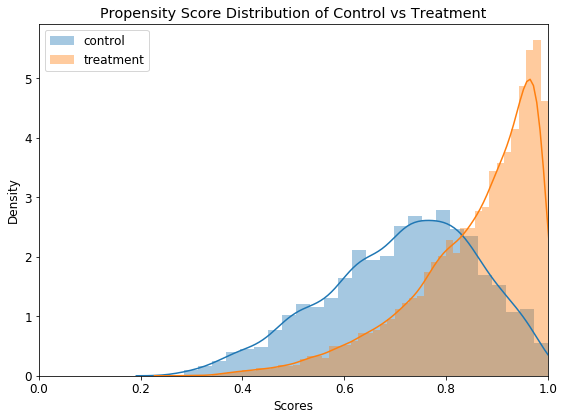

In [46]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)

In [61]:
caliper = 1
df_pos = df_final[mask][sim_distances < caliper]
df_neg = df_final[~mask].iloc[sim_indices[:, 0]][sim_distances < caliper]

In [62]:
df_pos.shape

(15585, 21)

In [63]:
for column in df_pos.columns:
    if (df_pos[column].dtypes != 'object') & (column != 'treatment'):
        statistic, pvalue = stats.ttest_ind(df_pos[column], df_neg[column], equal_var=False)
        if pvalue < 0.05:
            if column == 'DIAS_LIBRE':
                y_1 = df_pos[column].mean()
                y_2 = df_neg[column].mean()
                print(f'Treatment is significant, its TTE is {y_2 - y_1} with p-value {pvalue}')
            else:
                print(f'{column} is not balanced, its statistic is {statistic} with p-value {pvalue}')
        

Treatment is significant, its TTE is -30.577462135130077 with p-value 0.00022621582109411708
EDAD is not balanced, its statistic is -4.734571440834069 with p-value 2.205248482988981e-06
DIAS_CONDENA is not balanced, its statistic is -14.010923832623428 with p-value 1.8600150742201268e-44
CENSURADO_LIBRES is not balanced, its statistic is 6.388386998322113 with p-value 1.7003338700033062e-10
NUMERO_REINCIDENCIAS is not balanced, its statistic is 14.013908826856161 with p-value 1.7670522190569796e-44
AGRAVADO_S is not balanced, its statistic is 8.484636894098518 with p-value 2.25836837131042e-17
CALIFICADO_S is not balanced, its statistic is 11.85642305340674 with p-value 2.3401233431774163e-32
GENERO_MASCULINO is not balanced, its statistic is 14.043753425656044 with p-value 1.167173868985496e-44
REGIONAL_NORTE is not balanced, its statistic is -8.348954963394293 with p-value 7.174925419477259e-17
REGIONAL_OCCIDENTE is not balanced, its statistic is -2.714312371742343 with p-value 0.006

In [64]:
results = logrank_test(df_pos['DIAS_LIBRE'], df_neg['DIAS_LIBRE'], 
                       event_observed_A=df_pos['CENSURADO_LIBRES'], 
                       event_observed_B=df_neg['CENSURADO_LIBRES'])
results.print_summary()

In [140]:
import statsmodels.api as sm # import stastmodels
import statsmodels.formula.api as smf # this allows us to use an explicit formulation
 

# calculate propensity score weights for ATT (Austin, 2011)
df_final['wt'] = np.where(df_final['treatment']==1, 1,pscore/(1-pscore))

df_pos = df_final[df_final['treatment'].isin([1])]  
df_neg = df_final[df_final['treatment'].isin([0])]

count    43492.000000
mean         1.719169
std          3.843056
min          0.030039
25%          1.000000
50%          1.000000
75%          1.000000
max        168.287041
Name: wt, dtype: float64

In [ ]:
# descriptives for unmatched or unweighted data
np.average(trt.black)
np.average(ctrl.black)

np.average(trt.re74)
np.average(ctrl.re74)

np.average(trt.age)
np.average(ctrl.age)

# descriptives with weighted data
np.average(trt.black, weights =  trt.wt)
np.average(ctrl.black, weights = ctrl.wt)

np.average(trt.re74, weights =  trt.wt)
np.average(ctrl.re74, weights = ctrl.wt)

np.average(trt.age, weights =  trt.wt)
np.average(ctrl.age, weights = ctrl.wt)

#----------------------------------------
# estimation of treatment effects
#----------------------------------------

### unweighted comparisons

# regression using smf
lmresults = smf.ols('re78 ~ treat', data=df).fit()

# inspect results
lmresults.summary()  # b_est = -635

### weighted comparisons

# weighted differences in outcome
np.average(trt.re78, weights =  trt.wt)
np.average(ctrl.re78, weights = ctrl.wt)

# iptw regression
iptwResults = smf.wls('re78 ~ treat', data=df, weights = df.wt).fit()
iptwResults.summary() # b_est =  1214

#### Trabajo

In [17]:
df = df_mj.copy()
df['NIVEL_EDUCATIVO'] = df['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 13, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

df['ESTADO_INGRESO'] = df['ESTADO_INGRESO'].replace(
            {'Prision Domiciliaria': 'Detencion Domiciliaria',
             'Vigilancia Electronica': 'Intramuros',
             'Control Electronico': 'Intramuros',
             'Espera Traslado': 'Intramuros'
            })

treat_df = df.drop_duplicates('INTERNOEN')
treat_df = treat_df.loc[treat_df['ACTIVIDADES_TRABAJO'] == 'SI', ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

untreat_df = df.drop_duplicates('INTERNOEN')
untreat_df = untreat_df[(untreat_df['ACTIVIDADES_TRABAJO'] == 'NO') & (untreat_df['ACTIVIDADES_ESTUDIO'] == 'NO') & (untreat_df['ACTIVIDADES_ENSEÑANZA'] == 'NO')]
untreat_df = untreat_df.loc[untreat_df['INTERNOEN'].isin(set(untreat_df['INTERNOEN']).difference(set(treat_df))), ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

dummies_df = pd.get_dummies(df[['ESTADO', 'TENTATIVA', 'AGRAVADO', 'CALIFICADO', 'GENERO', 
                      'REGIONAL', 'ESTADO_INGRESO', 'HIJOS_MENORES', 'ESTADO_CIVIL']], drop_first = True)

dummies_df.columns = [string.replace(' ', '_') for string in dummies_df.columns]
dummies_df.columns = [string.replace('(', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace(')', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace('-', '_')  for string in dummies_df.columns]

treat_df = treat_df.merge(dummies_df, right_index = True, left_index = True)
untreat_df = untreat_df.merge(dummies_df, right_index = True, left_index = True)

drops = list(set(treat_df.columns[np.where(treat_df.std() < 0.1)]).union(set(untreat_df.columns[np.where(untreat_df.std() == 0)])))

treat_df.drop(columns = drops, inplace = True)
untreat_df.drop(columns = drops, inplace = True)

treat_df['treatment'] = 1
untreat_df['treatment'] = 0

df_final = pd.concat([treat_df, untreat_df], axis =0)
df_final = df_final[(~df_final['DIAS_CONDENA'].isnull()) & (~df_final['NIVEL_EDUCATIVO'].isnull())]

In [18]:
treatment = df_final.iloc[:,-1]
data = df_final.iloc[:, 1:-1]

In [123]:
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(data, treatment)
pscore = logistic.predict_proba(data)[:, 1]
auc = roc_auc_score(treatment, pscore)
print(f'AUC is: {auc}')
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

AUC is: 0.7719933178548362
treatment count: (39075,)
control count: (4417,)


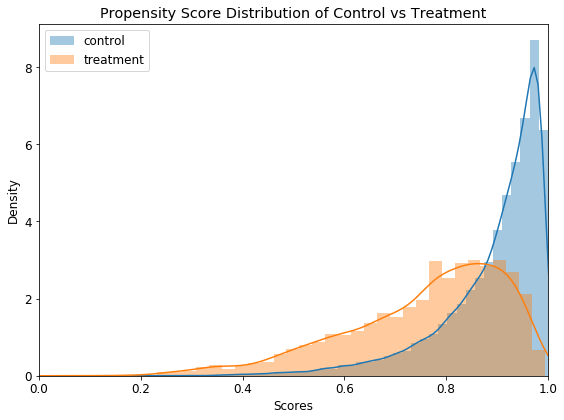

In [23]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[10352],
       [13035],
       [20665],
       ...,
       [29843],
       [21203],
       [20533]], dtype=int64)

In [25]:
caliper = 1
df_pos = df_final[mask][sim_distances < caliper]
df_neg = df_final[~mask].iloc[sim_indices[:, 0]][sim_distances < caliper]

In [26]:
df_pos.shape

(4417, 22)

In [27]:
for column in df_pos.columns:
    if (df_pos[column].dtypes != 'object') & (column != 'treatment'):
        statistic, pvalue = stats.ttest_ind(df_pos[column], df_neg[column], equal_var=False)
        if pvalue < 0.05:
            if column == 'DIAS_LIBRE':
                y_1 = df_pos[column].mean()
                y_2 = df_neg[column].mean()
                print(f'Treatment is significant, its TTE is {y_2 - y_1} with p-value {pvalue}')
            else:
                print(f'{column} is not balanced, its statistic is {statistic} with p-value {pvalue}')
        

CALIFICADO_S is not balanced, its statistic is 2.27229658390399 with p-value 0.023092547443017857


In [28]:
results = logrank_test(df_pos['DIAS_LIBRE'], df_neg['DIAS_LIBRE'], 
                       event_observed_A=df_pos['CENSURADO_LIBRES'], 
                       event_observed_B=df_neg['CENSURADO_LIBRES'])
results.print_summary()

#### Enseñanza

In [150]:
df = df_mj.copy()
df['NIVEL_EDUCATIVO'] = df['NIVEL_EDUCATIVO'].map(
            {'ANALFABETA': 0, 'CICLO I': 2, 'CICLO II': 5, 'CICLO III': 9,
            'CICLO IV': 11, 'TECNICO': 13, 'TECNOLOGICO': 13, 'PROFESIONAL': 16,
            'MAGISTER': 18, 'POST GRADO': 18})

df['ESTADO_INGRESO'] = df['ESTADO_INGRESO'].replace(
            {'Prision Domiciliaria': 'Detencion Domiciliaria',
             'Vigilancia Electronica': 'Intramuros',
             'Control Electronico': 'Intramuros',
             'Espera Traslado': 'Intramuros'
            })

treat_df = df.drop_duplicates('INTERNOEN')
treat_df = treat_df.loc[treat_df['ACTIVIDADES_ENSEÑANZA'] == 'SI', ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

untreat_df = df.drop_duplicates('INTERNOEN')
untreat_df = untreat_df[(untreat_df['ACTIVIDADES_TRABAJO'] == 'NO') & (untreat_df['ACTIVIDADES_ESTUDIO'] == 'NO') & (untreat_df['ACTIVIDADES_ENSEÑANZA'] == 'NO')]
untreat_df = untreat_df.loc[untreat_df['INTERNOEN'].isin(set(untreat_df['INTERNOEN']).difference(set(treat_df))), ['DIAS_LIBRE', 'EDAD', 'ANO_INGRESO_INT', 'DIAS_CONDENA', 'CENSURADO_LIBRES', 'NUMERO_REINCIDENCIAS', 'NIVEL_EDUCATIVO']]

dummies_df = pd.get_dummies(df[['ESTADO', 'TENTATIVA', 'AGRAVADO', 'CALIFICADO', 'GENERO', 
                      'REGIONAL', 'ESTADO_INGRESO', 'HIJOS_MENORES', 'ESTADO_CIVIL']], drop_first = True)

dummies_df.columns = [string.replace(' ', '_') for string in dummies_df.columns]
dummies_df.columns = [string.replace('(', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace(')', '_')  for string in dummies_df.columns]
dummies_df.columns = [string.replace('-', '_')  for string in dummies_df.columns]

treat_df = treat_df.merge(dummies_df, right_index = True, left_index = True)
untreat_df = untreat_df.merge(dummies_df, right_index = True, left_index = True)

drops = list(set(treat_df.columns[np.where(treat_df.std() < 0.1)]).union(set(untreat_df.columns[np.where(untreat_df.std() == 0)])))

treat_df.drop(columns = drops, inplace = True)
untreat_df.drop(columns = drops, inplace = True)

treat_df['treatment'] = 1
untreat_df['treatment'] = 0

df_final = pd.concat([treat_df, untreat_df], axis =0)
df_final = df_final[(~df_final['DIAS_CONDENA'].isnull()) & (~df_final['NIVEL_EDUCATIVO'].isnull())]

In [151]:
treatment = df_final.iloc[:,-1]
data = df_final.iloc[:, 1:-1]

In [124]:
logistic = LogisticRegression(solver = 'liblinear')
logistic.fit(data, treatment)
pscore = logistic.predict_proba(data)[:, 1]
auc = roc_auc_score(treatment, pscore)
print(f'AUC is: {auc}')
mask = treatment == 1
pos_pscore = pscore[mask]
neg_pscore = pscore[~mask]
print('treatment count:', pos_pscore.shape)
print('control count:', neg_pscore.shape)

AUC is: 0.7719933178548362
treatment count: (39075,)
control count: (4417,)


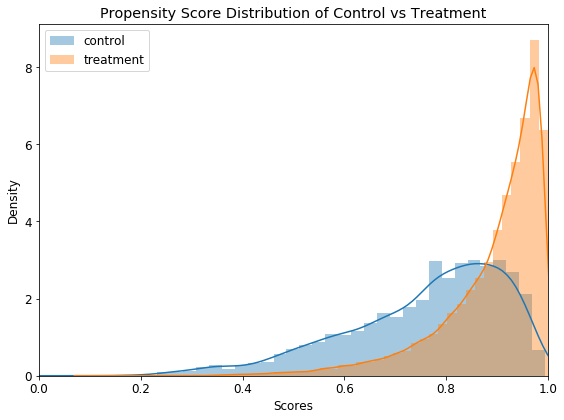

In [30]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

sns.distplot(neg_pscore, label='control')
sns.distplot(pos_pscore, label='treatment')
plt.xlim(0, 1)
plt.title('Propensity Score Distribution of Control vs Treatment')
plt.ylabel('Density')
plt.xlabel('Scores')
plt.legend()
plt.tight_layout()
plt.show()

In [157]:
def get_similar(pos_pscore: np.ndarray, neg_pscore: np.ndarray, topn: int=5, n_jobs: int=1):
    from sklearn.neighbors import NearestNeighbors

    knn = NearestNeighbors(n_neighbors=topn + 1, metric='euclidean', n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))

    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, 1:]
    sim_indices = indices[:, 1:]
    return sim_distances, sim_indices


sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)
sim_indices

array([[ 170],
       [ 558],
       [ 640],
       ...,
       [ 845],
       [1096],
       [ 766]], dtype=int64)

In [158]:
caliper = 1
df_pos = df_final[mask][sim_distances < caliper]
df_neg = df_final[~mask].iloc[sim_indices[:, 0]][sim_distances < caliper]

In [159]:
df_pos.shape

(4417, 22)

In [160]:
for column in df_pos.columns:
    if (df_pos[column].dtypes != 'object') & (column != 'treatment'):
        statistic, pvalue = stats.ttest_ind(df_pos[column], df_neg[column], equal_var=False)
        if pvalue < 0.05:
            if column == 'DIAS_LIBRE':
                y_1 = df_pos[column].mean()
                y_2 = df_neg[column].mean()
                print(f'Treatment is significant, its TTE is {y_2 - y_1} with p-value {pvalue}')
            else:
                print(f'{column} is not balanced, its statistic is {statistic} with p-value {pvalue}')
        

Treatment is significant, its TTE is -128.63538269747005 with p-value 1.6920728366031189e-09
EDAD is not balanced, its statistic is -3.3151922215655723 with p-value 0.0009196859513566017
ESTADO_Baja is not balanced, its statistic is -9.555293332256722 with p-value 1.928996762268671e-21
TENTATIVA_S is not balanced, its statistic is 6.9907152253577225 with p-value 2.950400016033513e-12
GENERO_MASCULINO is not balanced, its statistic is -6.21828545929086 with p-value 5.262830002807862e-10
REGIONAL_NOROESTE is not balanced, its statistic is -4.169236540311557 with p-value 3.085520866328999e-05
REGIONAL_NORTE is not balanced, its statistic is -2.1019524248940775 with p-value 0.035585729611016
REGIONAL_OCCIDENTE is not balanced, its statistic is 3.5229535065971547 with p-value 0.0004289313215551828
ESTADO_INGRESO_Intramuros is not balanced, its statistic is 6.818662597359929 with p-value 9.793304085493081e-12
ESTADO_CIVIL_SEPARADO_A_ is not balanced, its statistic is 2.2370813779495036 with 

In [149]:
results = logrank_test(df_pos['DIAS_LIBRE'], df_neg['DIAS_LIBRE'], 
                       event_observed_A=df_pos['CENSURADO_LIBRES'], 
                       event_observed_B=df_neg['CENSURADO_LIBRES'])
results.print_summary()